In [1]:
!nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-783e94e2-862f-e0b1-a28c-28dcfcc20c82)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.compat.v2.feature_column as feature_column
import tensorflow as tf

In [3]:
train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
test = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = train.pop('survived')
y_test = test.pop('survived')

In [4]:
train.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
train.shape[0], test.shape[0]

(627, 264)

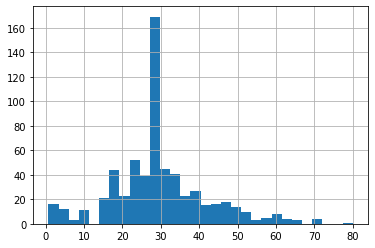

In [7]:
train.age.hist(bins = 30)

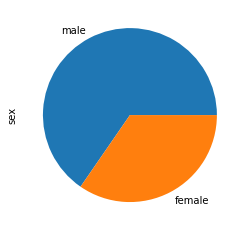

In [8]:
train.sex.value_counts().plot(kind = 'pie')

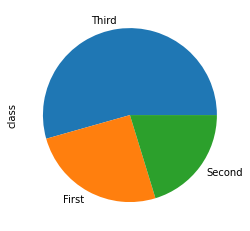

In [9]:
train['class'].value_counts().plot(kind ='pie')

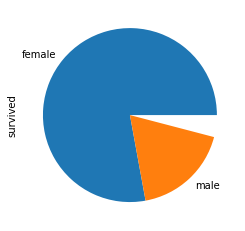

In [10]:
pd.concat([train, y_train], axis=1).groupby('sex').survived.mean().plot(kind = 'pie')

In [11]:
CATEGORICAL = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERICAL = ['age', 'fare']

feature_columns = []
for feature in CATEGORICAL:
  vocab = train[feature].unique()
  feature_columns.append(feature_column.categorical_column_with_vocabulary_list(feature, vocab))
for feature in NUMERICAL:
  feature_columns.append(feature_column.numeric_column(feature, dtype=tf.float32))

feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [12]:
def make_input_fn(data, label, epoch = 10, randomize = True, batch_size = 32):
  def input_func():
    x = tf.data.Dataset.from_tensor_slices((dict(data), label))
    if randomize:
      x = x.shuffle(500)
    x = x.batch(batch_size).repeat(epoch)
    return x
  return input_func

train_input = make_input_fn(train, y_train)
test_input = make_input_fn(test, y_test, epoch=1, randomize=False)

In [13]:
x = make_input_fn(train, y_train, batch_size=10)()

for feature_batch, label_batch in x.take(1):
  print('Some feature keys:', list(feature_batch.keys()), '\n')
  print('A batch of class:', feature_batch['class'].numpy(), '\n')
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone'] 

A batch of class: [b'First' b'First' b'Second' b'Third' b'Third' b'Second' b'First' b'First'
 b'Third' b'Third'] 

A batch of Labels: [0 1 0 0 0 1 1 0 0 1]


In [14]:
lin_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
lin_est.train(train_input)
res = lin_est.evaluate(test_input)

print('\nResult = ',res)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsiv4_3pz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initiali

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpsiv4_3pz/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 90.816
INFO:tensorflow:loss = 0.58229333, step = 100 (1.104 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmpsiv4_3pz/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...
INFO:tensorflow:Loss for final step: 0.47605455.
INFO:tensorflow:Calling model_fn.
I

### Derived Featured Columns

In [15]:
age_class_gender = tf.feature_column.crossed_column(['age', 'class', 'sex'], hash_bucket_size=100)

derived_feature_columns = [age_class_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns + derived_feature_columns)
linear_est.train(train_input)
result = linear_est.evaluate(test_input)

print('\nResult:' ,result)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp7z3nhwgr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp7z3nhwgr/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 82.4857
INFO:tensorflow:loss = 0.4942637, step = 100 (1.217 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 200...
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmp7z3nhwgr/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 200...
INFO:tensorflow:Loss for final step: 0.3534011.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-03-08T03:41:48Z
INFO:tensorflow:Graph

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp7z3nhwgr/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


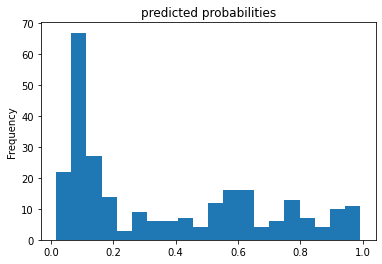

In [16]:
predictions = list(linear_est.predict(test_input))
probability = pd.Series([x['probabilities'][1] for x in predictions])

probability.plot(kind='hist', bins=20, title='predicted probabilities')

(0.0, 1.05)

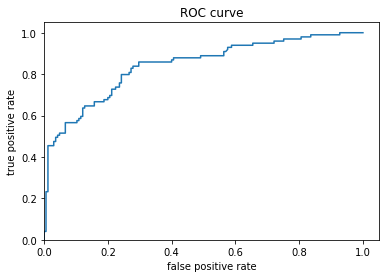

In [17]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_test, probability)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)